## Librerias Necesarias

In [2]:

import numpy as np
import CPMP_attention_model as cpmp_att
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Funciones para entrenamiento y predicciones

In [3]:
#************ | expand_dims_cpmp() | **************#
# El proposito de esta función es expandir las     #
# dimensiones de un estado menor para que pueda    #
# ser predicho un por modelo para un estado mayor. #
#                                                  #
# Input:                                           #
#     - data: Lista de matrices con todos los      #
#             estados.                             #
#     - labels: lista de posibles stacks de origen #
#               o destino.                         #
#     - stacks: Cantidad de stacks permitidos por  #    
#               el modelo.                         #
#     - height: Altura máxima de los stacks        #
#               permitidos por el modelo.          #
#                                                  #
# Output:                                          #
#      Retona un arreglo de los datos              #
#      redimensionados con sus respectivos labels. #
def expand_dims_cpmp(data, labels, stacks, height):
    size = data.shape[1]
    tuple_data = zip(data, labels)
    data_2 = []
    labels_2 = []

    for matrix, label in tuple_data:
        matrix = matrix.tolist()
        label = label.tolist()
        for i in range(stacks - size):
            matrix.append([1] + [1 for n in range(height)])
            label.append(0)

        data_2.append(matrix)
        labels_2.append(label)

    return np.array(data_2), np.array(labels_2)

In [4]:
#************* | is_equal() | **************#
# El proposito de esta función es verificar #
# si los datos ingresados en dos arreglos   #
# son exactamente iguales independiente de  #
# su posición.                              #
#                                           #
# Input:                                    #
#     - array1: Primer arreglo que se       #
#               desea comparar.             #
#     - array2: Segundo arreglo que se      #
#               desea comparar.             #
# Output:                                   #
#     Retorna true en el caso de tener      #
#     cada dato exactamente igual o         #
#     False en caso contrario.              #
def is_equal(array1, array2):
    size = len(array1)
    cant = 0
    array1.sort()
    array2.sort()

    for i in range(size):
        if array1[i] == array2[i]:
            cant += 1

    if cant == size: return True

    return False

In [5]:
#***************** | precision() | ***************#
# El proposito de esta función es verificar si    #
# los valores predichos por una red neuronal son  #
# correctos o no.                                 #
#                                                 #
# Input:                                          #
#     - y_predict: Valores predichos por el       #
#                  mecanismo de machine learning. #
#     - y_test: Valores reales de los casos       #
#               predichos.                        #
# Output:                                         #
#     Retorna una proporción entre los valores    #
#     predichos correctamente sobre la cantidad   #
#     de datos.                                   #
def precision(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        if np.argmax(y_predict[i]) == np.argmax(y_test[i]):
            predict += 1
    
    return predict / size

In [6]:
#************** | precision_for_multiclass() | ***************#
# El proposito de esta función es verificar si los valores    #
# predichos por un mecanismo de machine learning para         #
# clasificación multiclase están correctos o no.              #
#                                                             # 
# Input:                                                      #
#     - y_predict: Valores predichos por el mecanismo de      #
#                  machine learning.                          #
#     - y_test: Valores reales de cada caso.                  #
# Output:                                                     #
#     Retorna una proporción entre los valores predichos      #
#     correctamente sobre la cantidad total de casos.         #
def precision_for_multiclass(y_predict, y_test):
    size = len(y_predict)
    predict = 0

    for i in range(size):
        cant_sol = np.count_nonzero(y_test[i] == 1.)
        
        indices_test = np.argsort(y_test[i])
        indices_test = indices_test[-cant_sol:]
        indices_predict = np.argsort(y_predict[i])
        indices_predict = indices_predict[-cant_sol:]

        if is_equal(indices_test, indices_predict):
            predict += 1
    
    return predict / size

## Funciones para cargar y guardar data

In [7]:
#************** | load_data() | ************#
# El proposito de esta función es cargar    #
# los datos almacenados en un csv para el   #
# entrenamiento de la red neuronal.         #
#                                           #
# Input:                                    #
#     - name: Nombre del archivo con su     #
#             dirección correspondiente     #
#             sin el .csv.                  #
#                                           #
# Output:                                   #
#      Retorna 3 arreglos, el primero       #
#      corresponde a una lista de estados,  #
#      el segundo a una lista de labels     #
#      de stacks de origen y por último una #
#      lista de posibles stacks de destino. #
def load_data(name):
    data = []
    labels_1 = []
    labels_2 = []

    with open(name + '.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)
            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(labels_1), np.stack(labels_2)

In [8]:
def load_data_multi(name):
    data = []
    data_2 = []
    labels_1 = []
    labels_2 = []

    with open(name + '_so.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_1 = archivo.readline().split(':')[1].split(',')
            label_1 = np.array(label_1, dtype= float)

            data.append(matrix)
            labels_1.append(label_1)

            archivo.readline()

    with open(name + '_sd.csv', 'r') as archivo:
        total = int(archivo.readline().split(':')[1])
        line = archivo.readline().split(':')
        size_stacks = int(line[1].split(',')[0])
        size_height = int(line[2])
        archivo.readline()

        for i in range(total):
            matrix = archivo.readline().split(':')[1].split(',')
            matrix = np.array(matrix, dtype= float)
            matrix = np.reshape(matrix, (size_stacks, size_height))

            label_2 = archivo.readline().split(':')[1].split(',')
            label_2 = np.array(label_2, dtype= float)

            data_2.append(matrix)
            labels_2.append(label_2)

            archivo.readline()

    return np.stack(data), np.stack(data_2), np.stack(labels_1), np.stack(labels_2)

# Cargar Data

In [9]:
data_7x7_so, data_7x7_sd, labels_7x7_so, labels_7x7_sd = load_data_multi('data/data_7x7_Multiple')

In [10]:
data_5x5_so, data_5x5_sd, labels_5x5_so, labels_5x5_sd = load_data_multi('data/data_5x5_Multiple')

# Modelo con Varias Salidas

## Modelo 5x5

In [ ]:
model_5x5_multi = cpmp_att.CPMP_attention_model()

In [ ]:
model_5x5_multi.create_model(num_layer_attention_add_so= 2, num_layer_attention_add_sd= 2, heads_so= 5, heads_sd= 5,
                             S= 5, H= 5, optimizer= 'Adam')

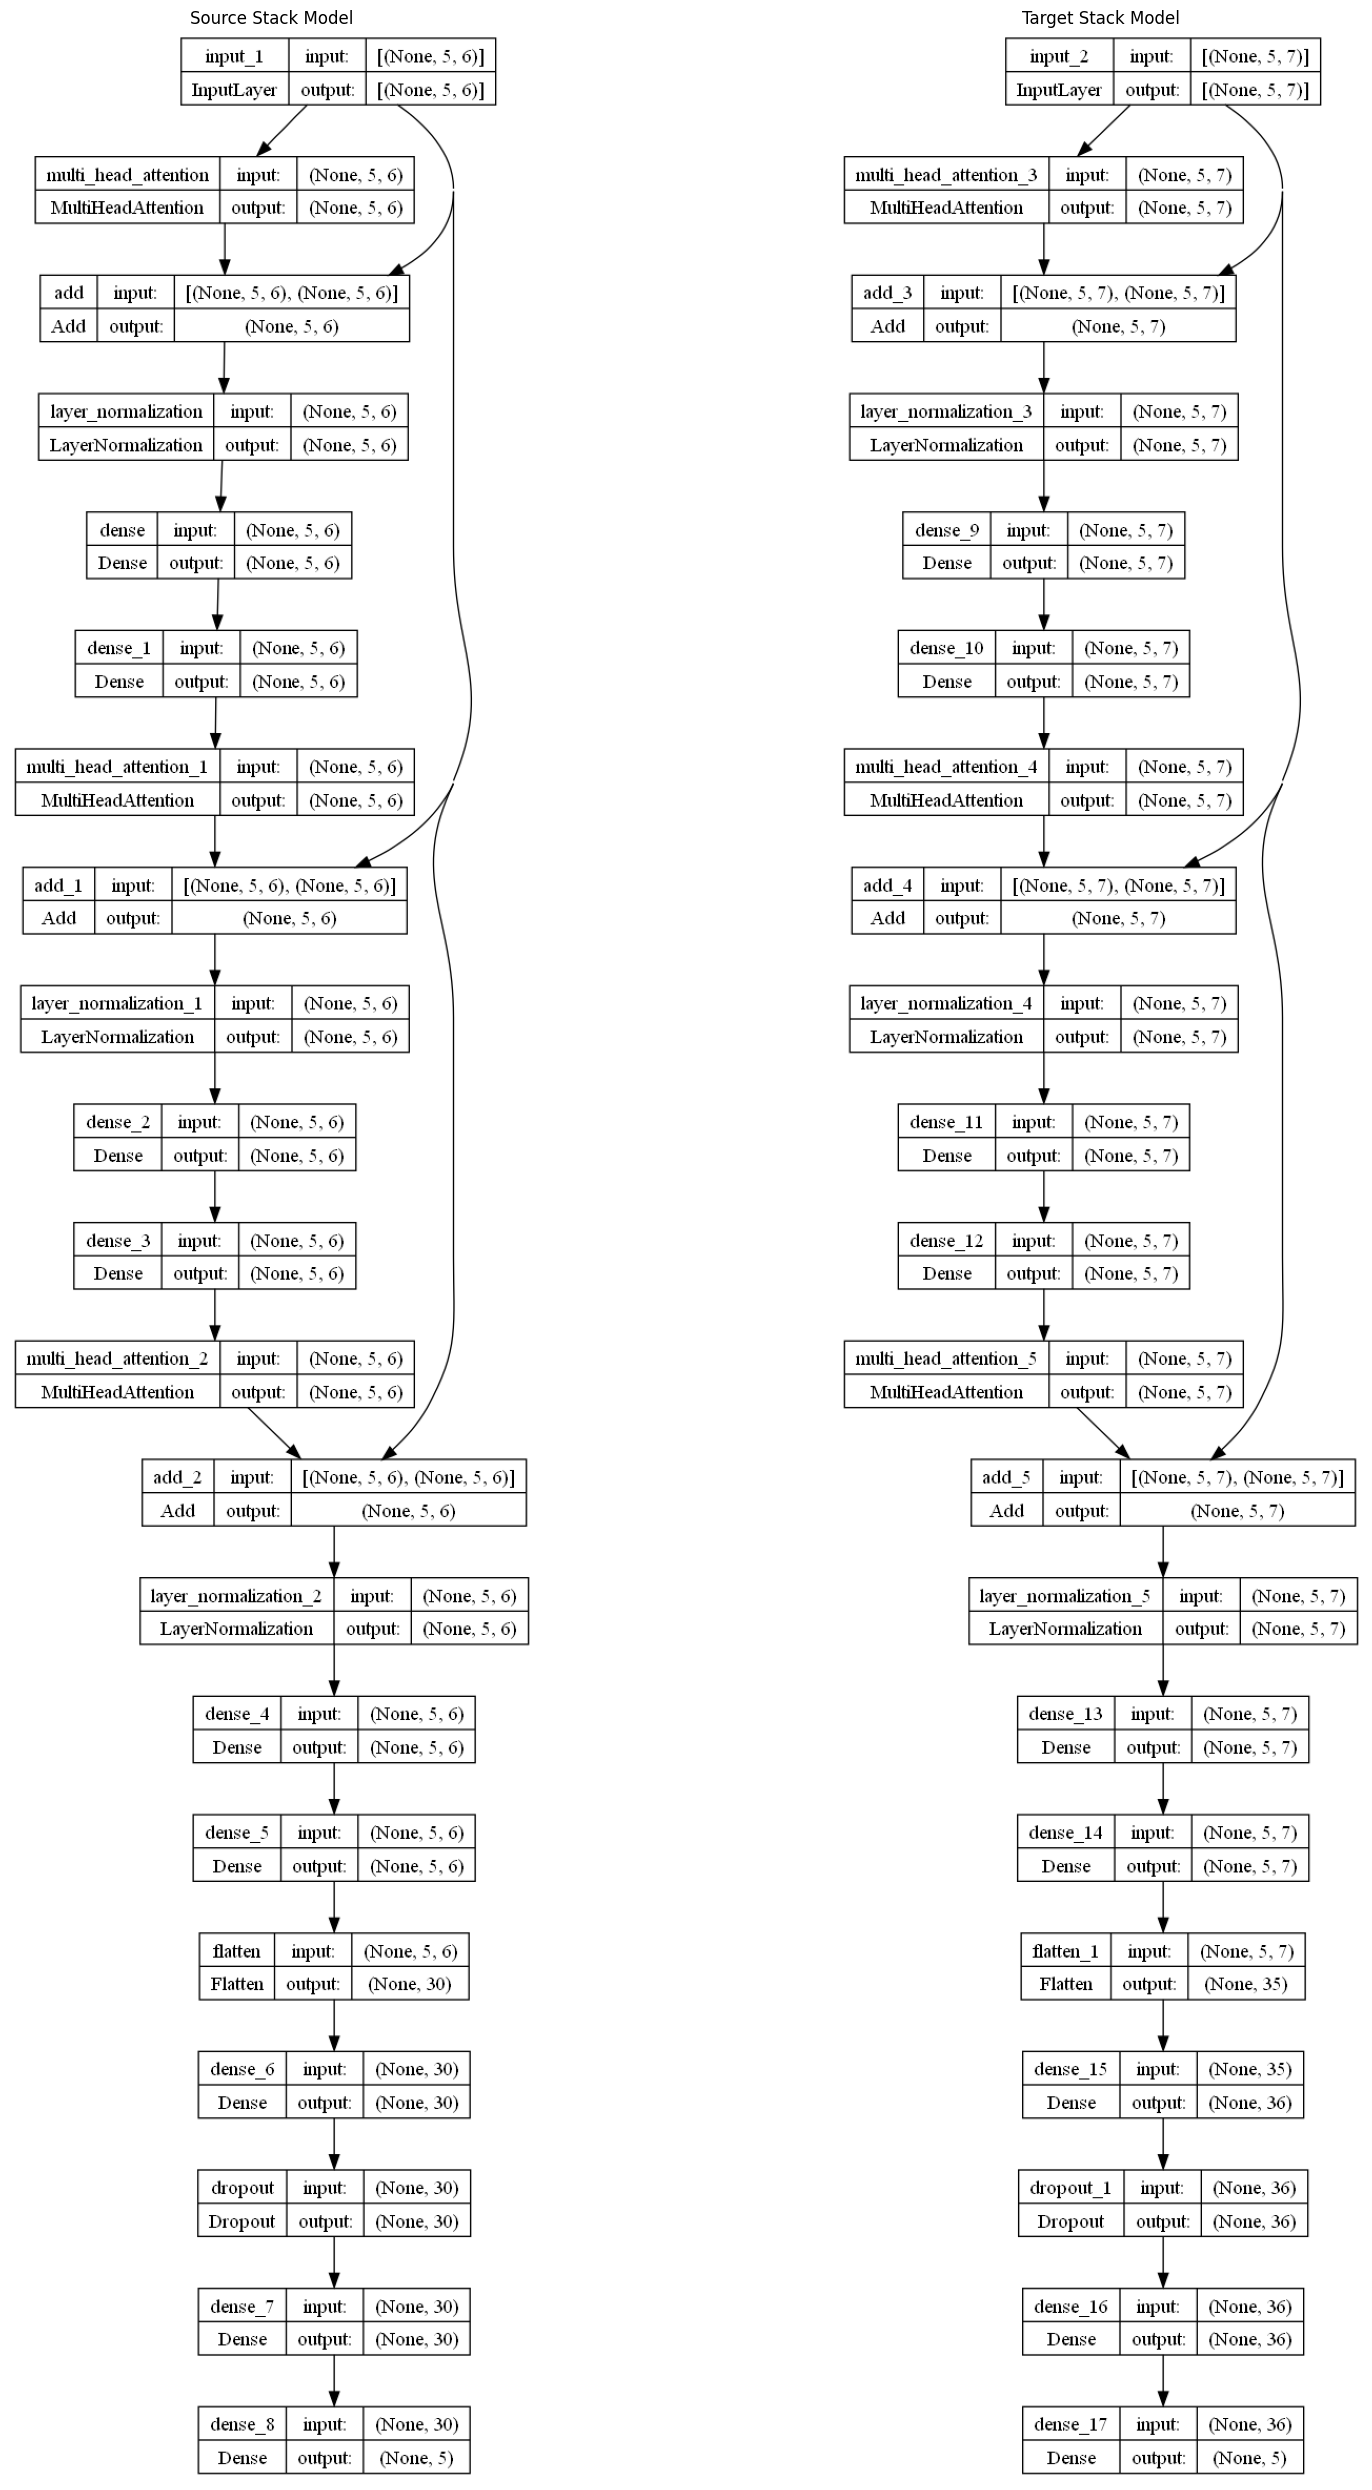

In [ ]:
model_5x5_multi.plot_model(name= 'images_models/model_cpmp_multi')

### Entrenamiento

In [ ]:
X_train_5x5_multi_so, X_test_5x5_multi_so, y_train_5x5_multi_so, y_test_5x5_multi_so = train_test_split(data_5x5_so, labels_5x5_so, 
                                                                                                        test_size= 0.2, random_state= 42)
X_train_5x5_multi_sd, X_test_5x5_multi_sd, y_train_5x5_multi_sd, y_test_5x5_multi_sd = train_test_split(data_5x5_sd, labels_5x5_sd, 
                                                                                                        test_size= 0.2, random_state= 42)

In [ ]:
history_so, history_sd = model_5x5_multi.fit(X_train_5x5_multi_so, X_train_5x5_multi_sd, 
                                             y_train_5x5_multi_so, y_train_5x5_multi_sd, 
                                             epochs= 50, verbose= True)

Historial SO:
Epoch 1/50
5000/5000 [==============================] - 24s 4ms/step - loss: 0.3864 - mae: 0.2661 - mse: 0.1269
Epoch 2/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.2482 - mae: 0.1600 - mse: 0.0776
Epoch 3/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.2027 - mae: 0.1300 - mse: 0.0629
Epoch 4/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.1831 - mae: 0.1165 - mse: 0.0568
Epoch 5/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.1736 - mae: 0.1093 - mse: 0.0537
Epoch 6/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.1662 - mae: 0.1041 - mse: 0.0513
Epoch 7/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.1603 - mae: 0.0999 - mse: 0.0494
Epoch 8/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.1561 - mae: 0.0970 - mse: 0.0480
Epoch 9/50
5000/5000 [==============================] - 20s 4ms/step - loss: 0.1517 - mae:

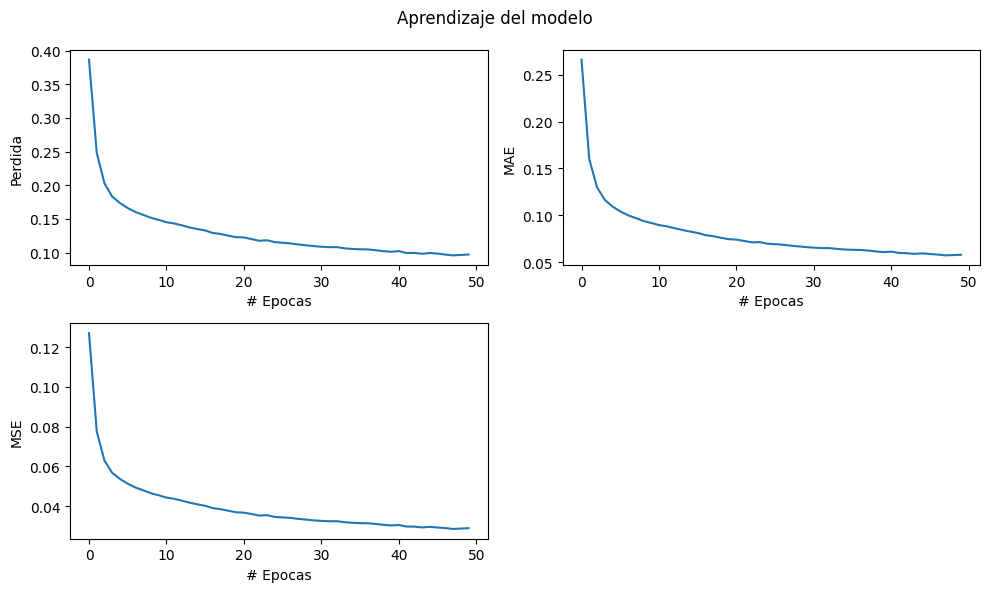

In [ ]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(history_so.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(history_so.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(history_so.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

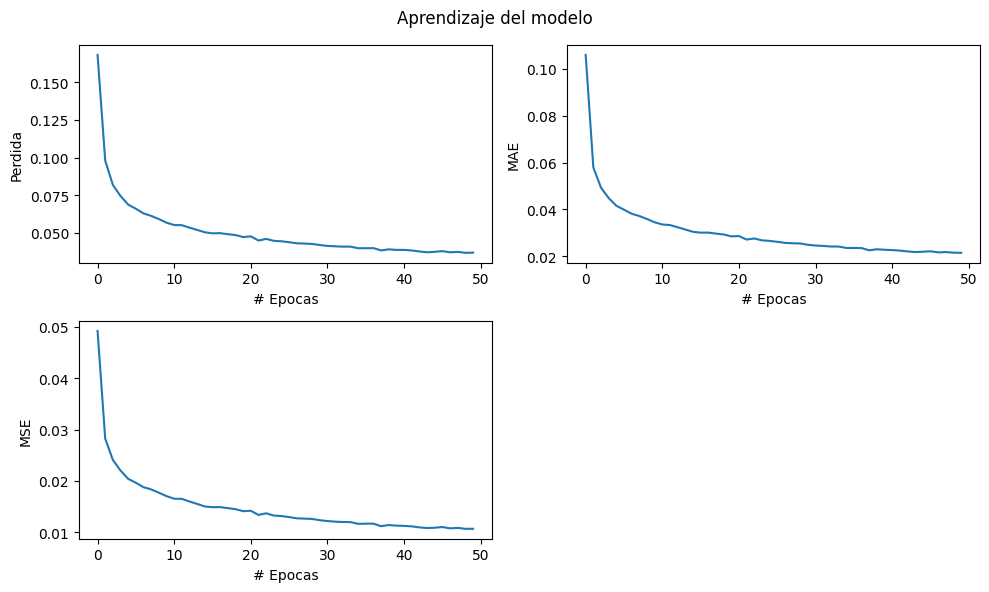

In [ ]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(history_sd.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(history_sd.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(history_sd.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

### Carga del último modelo entrenado

In [ ]:
model_5x5_multi.set_models('models/model_cpmp_origin_5x5_multi.h5',
                           'models/model_cpmp_dest_5x5_multi.h5')

### Predicción

In [ ]:
predict_5x5_so_multi = model_5x5_multi.predict_so(X_test_5x5_multi_so)
predict_5x5_sd_multi = model_5x5_multi.predict_sd(X_test_5x5_multi_sd)

results_5x5_so = precision_for_multiclass(predict_5x5_so_multi, y_test_5x5_multi_so)
results_5x5_sd = precision_for_multiclass(predict_5x5_sd_multi, y_test_5x5_multi_sd)

print(f"\nPrecisión Stack origen: {round(results_5x5_so * 100, 3)}%")
print(f"Precisión Stack destino: {round(results_5x5_sd * 100, 3)}%")

2048/2048 [==============================] - 5s 2ms/step

Precisión Stack origen: 97.858%
Precisión Stack destino: 99.457%


## Modelo 7x7

In [11]:
model_7x7_multi = cpmp_att.CPMP_attention_model()

In [12]:
model_7x7_multi.create_model(num_layer_attention_add_so= 3, num_layer_attention_add_sd= 3,
                             heads_so= 7, heads_sd= 5, S= 7, H= 7,
                             optimizer= 'Adam')

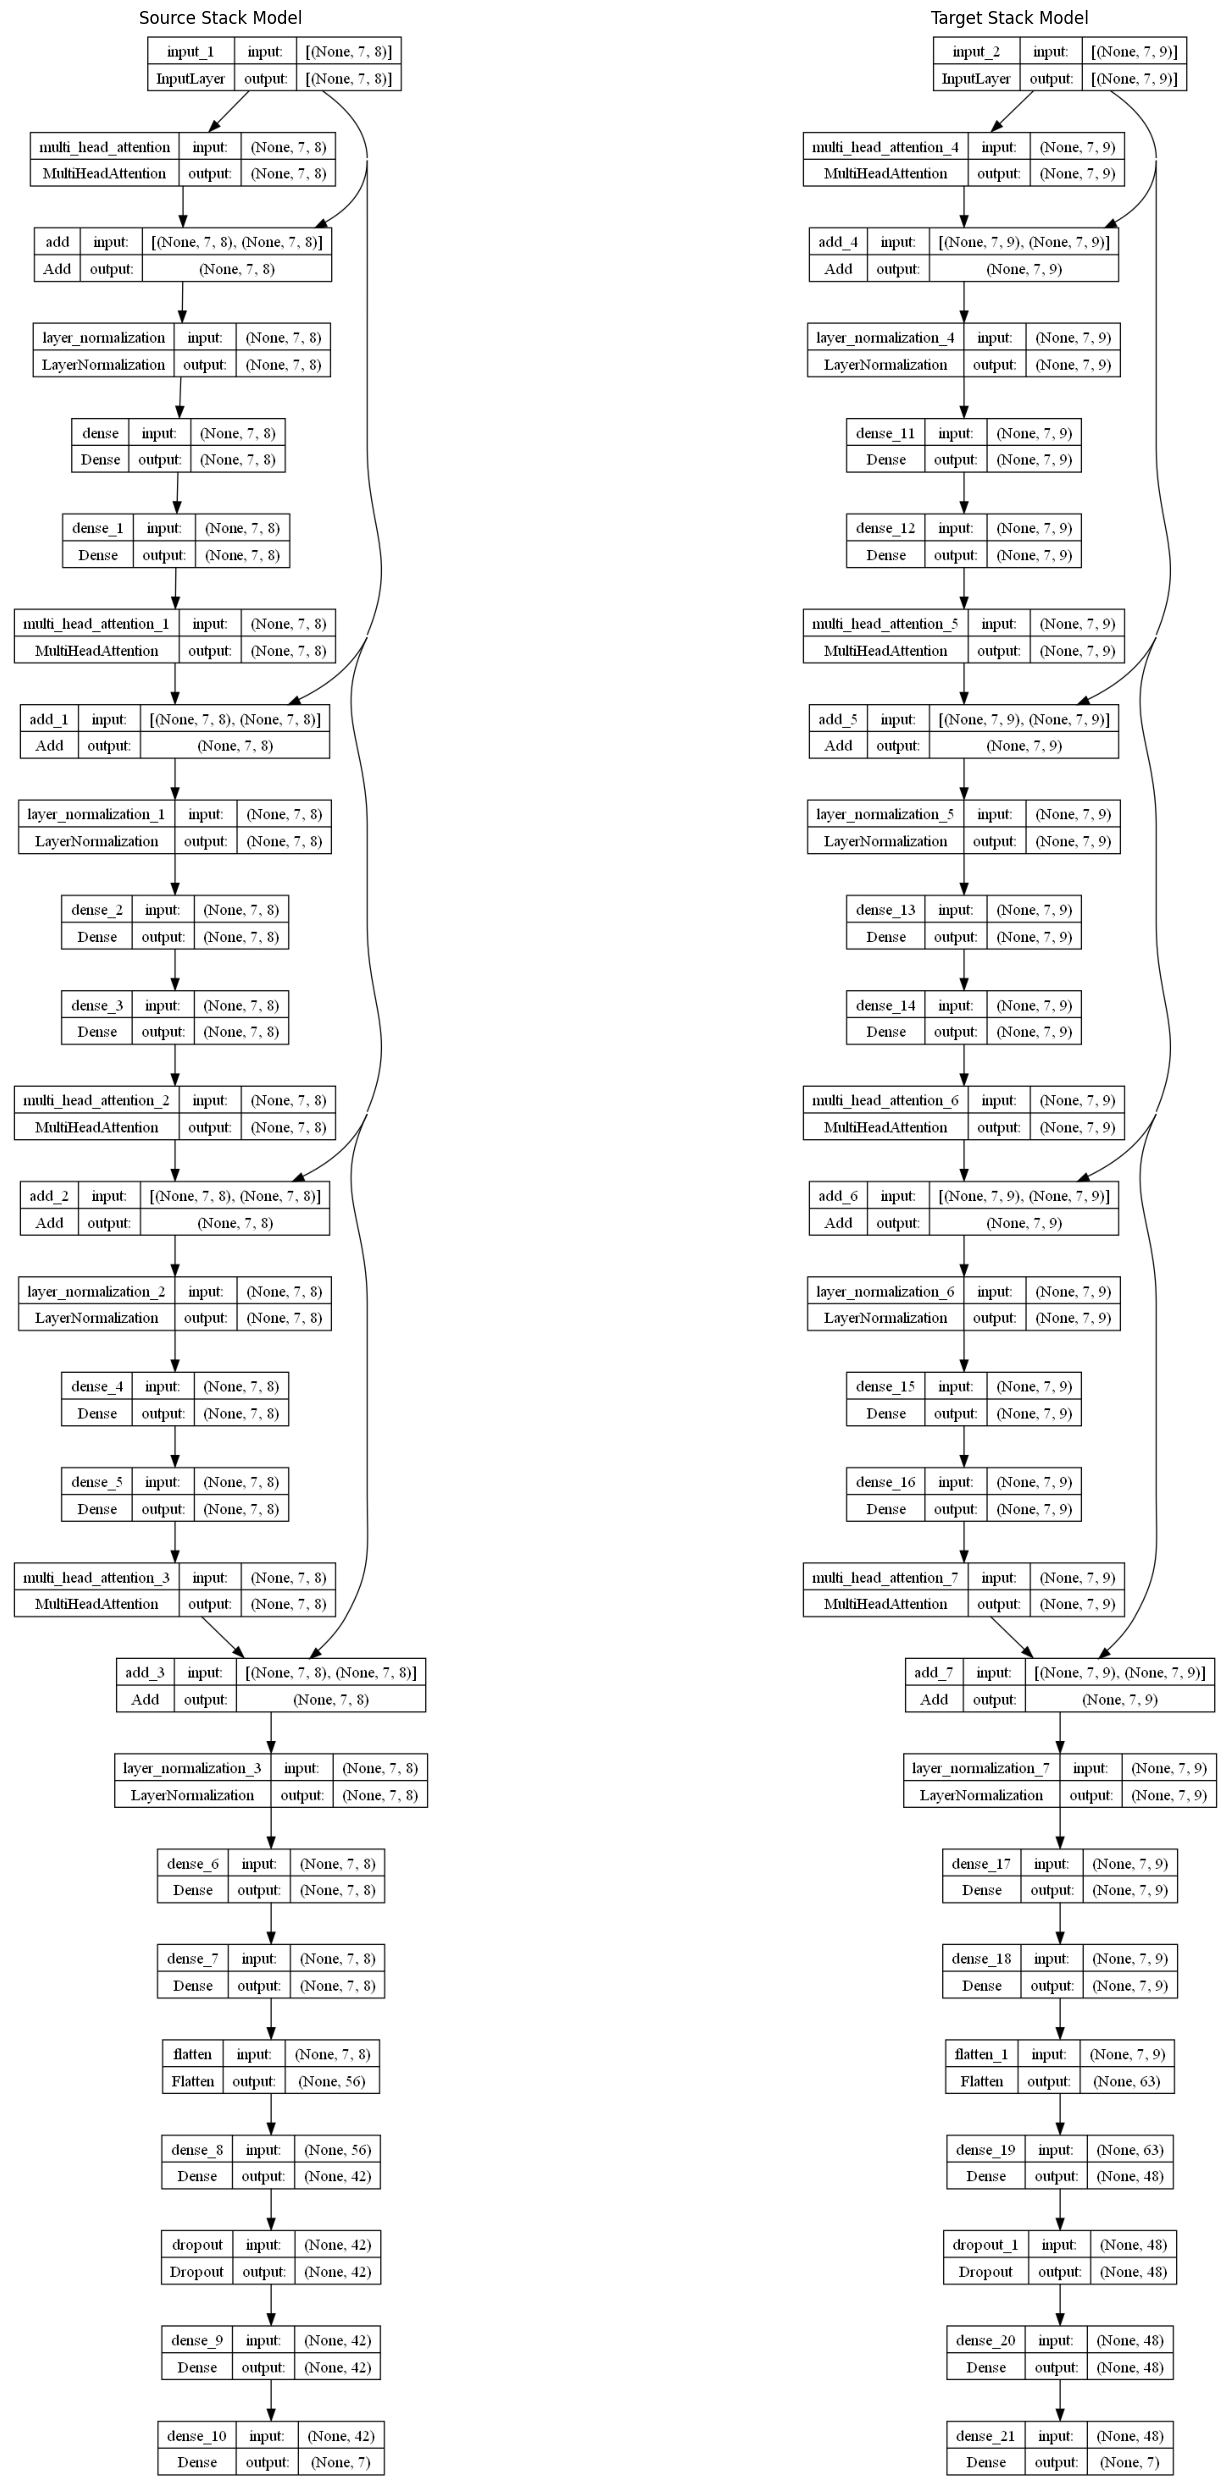

In [13]:
model_7x7_multi.plot_model(name= 'images_models/model_cpmp')

### Entrenamiento

In [14]:
X_train_7x7_multi_so, X_test_7x7_multi_so, y_train_7x7_multi_so, y_test_7x7_multi_so = train_test_split(data_7x7_so, labels_7x7_so, 
                                                                                                        test_size= 0.2, random_state= 42)
X_train_7x7_multi_sd, X_test_7x7_multi_sd, y_train_7x7_multi_sd, y_test_7x7_multi_sd = train_test_split(data_7x7_sd, labels_7x7_sd, 
                                                                                                        test_size= 0.2, random_state= 42)

In [15]:
history_so, history_sd = model_7x7_multi.fit(X_train_7x7_multi_so, X_train_7x7_multi_sd, 
                                             y_train_7x7_multi_so, y_train_7x7_multi_sd, 
                                             epochs= 50)

Historial SO:
Epoch 1/50
2500/2500 [==============================] - 19s 6ms/step - loss: 0.4921 - mae: 0.2981 - mse: 0.1935
Epoch 2/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.3900 - mae: 0.2436 - mse: 0.1641
Epoch 3/50
2500/2500 [==============================] - 14s 6ms/step - loss: 0.3599 - mae: 0.2261 - mse: 0.1562
Epoch 4/50
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3457 - mae: 0.2196 - mse: 0.1532
Epoch 5/50
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3369 - mae: 0.2161 - mse: 0.1520
Epoch 6/50
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3290 - mae: 0.2132 - mse: 0.1505
Epoch 7/50
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3232 - mae: 0.2111 - mse: 0.1495
Epoch 8/50
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3171 - mae: 0.2083 - mse: 0.1483
Epoch 9/50
2500/2500 [==============================] - 14s 5ms/step - loss: 0.3130 - mae:

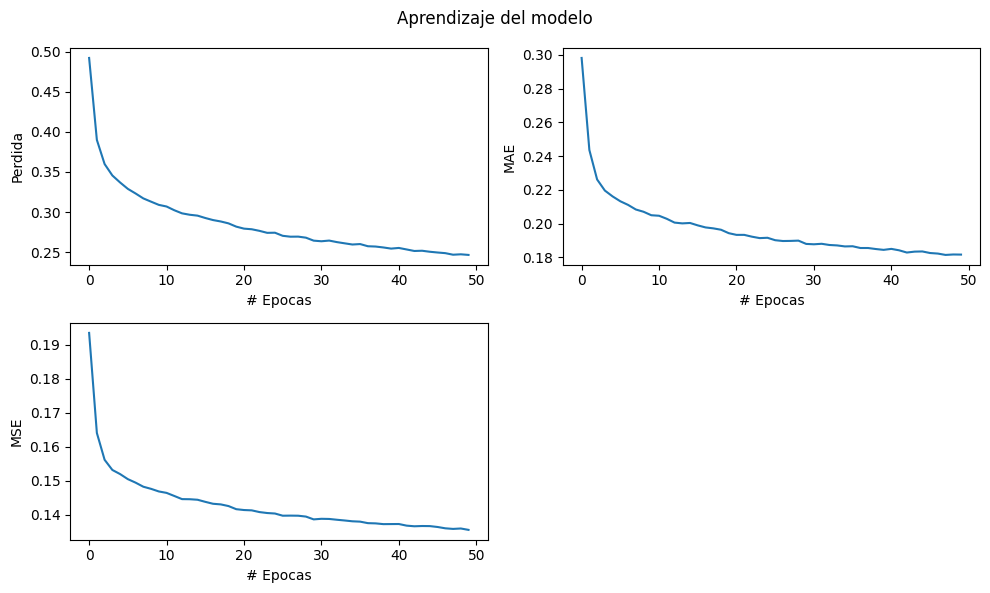

In [16]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(history_so.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(history_so.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(history_so.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

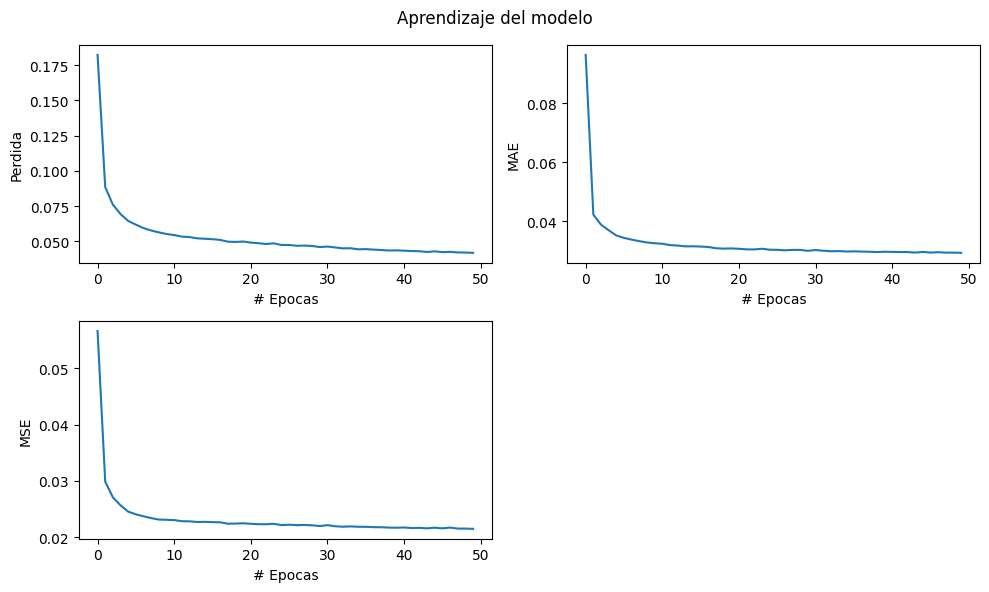

In [17]:
plt.figure(figsize= (10, 6))

plt.subplot(2, 2, 1)
plt.xlabel("# Epocas")
plt.ylabel("Perdida")
plt.plot(history_sd.history['loss'])

plt.subplot(2, 2, 2)
plt.xlabel("# Epocas")
plt.ylabel("MAE")
plt.plot(history_sd.history['mae'])

plt.subplot(2, 2, 3)
plt.xlabel("# Epocas")
plt.ylabel("MSE")
plt.plot(history_sd.history['mse'])

plt.suptitle('Aprendizaje del modelo')
plt.tight_layout()
plt.show()

### Cargar Modelo

### Predicciones

In [18]:
predict_7x7_so_multi = model_7x7_multi.predict_so(X_test_7x7_multi_so)
predict_7x7_sd_multi = model_7x7_multi.predict_sd(X_test_7x7_multi_sd)

results_7x7_so = precision_for_multiclass(predict_7x7_so_multi, y_test_7x7_multi_so)
results_7x7_sd = precision_for_multiclass(predict_7x7_sd_multi, y_test_7x7_multi_sd)

print(f"\nPrecisión Stack origen: {round(results_7x7_so * 100, 3)}%")
print(f"Precisión Stack destino: {round(results_7x7_sd * 100, 3)}%")

1263/1263 [==============================] - 4s 3ms/step

Precisión Stack origen: 87.57%
Precisión Stack destino: 98.904%


In [19]:
model_7x7_multi.save_models(name_so= 'models/model_cpmp_origin_7x7_multi.h5', 
                            name_sd= 'models/model_cpmp_dest_7x7_multi.h5')

c:\Users\matia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
